# Modelos de Regresión Logística

## 1. Introducción a la Regresión Logística

Se trata de un **algoritmo estadístico** cuyo objetivo es aproximar una **función matemática acotada** en el intervalo [0, 1]. Así permite la estimación de las **probabilidades de pertenencia** de cada muestra a las distintas clases. Como la detección de sexismo es un problema de clasificación binario, se establece el umbral en 0.5 con el que asignar una clase a cada instancia aplicando las siguientes casuísticas:

* Si la probabilidad es **menor que 0.5** entonces la clase es **no sexista** (categoría 0). 
* Si la probabilidad es **mayor que 0.5** entonces la clase es **sexista** (categoría 1).

### 1.1. Condiciones de uso

* **Mínima correlación** entre los predictores o variables independientes.
* La existencia de una **relación lineal** entre los predictores y la probabilidad de cada variable dependiente.
* Mínima existencia de **outliers**.
* Conjunto de datos razonáblemente amplio.

### 1.2. Casos de uso

1. Construir **modelos lineales** para solventar problemas de clasificación cuyos datos son fácilmente separables.

2. Comprobar de la existencia de **relaciones lineales** entre los predictores y la variable dependiente en función de los valores de los coeficientes del hiperplano.

   - Si es 0 significa que **no existe una relación lineal** entre un predictor y la variable dependiente por lo que dicho predictor no ayuda en su predicción.

   - Si es mayor que 0 supone un crecimiento simultáneo del predictor al aumentar la variable dependiente, mientras que si es menor que 0 simboliza el incremento del predictor cuando disminuye la variable dependiente. Aunque en ambos casos el **predictor puede ser útil para predecir** la clase de una muestra.

## 2. Estructura del notebook

1. Introducción a la Regresión Logística
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Técnicas de codificación de textos
6. Experimentos y modelos
7. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
import sys
sys.path.append('../scripts')

# Import data read and compute functions
from data import read_train_dataset, read_test_dataset

# Import text preprocess functions
from processing import *

# Import encoding functions
from encoding import *

# Import LR models and validation metrics
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Import plot lib to show the confussion matrixes
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/lidia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Lectura y carga de datos

En esta sección se pretende **cargar los datasets de entrenamiento y validación** procedentes de los correspondientes ficheros situados en la carpeta *data*. Al tener un **formato TSV** se deben leer como tablas aunque posteriormente se trabaje con ellos en formato *dataframe*. 

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.977 muestras**.
* Conjunto de validación: **4.368 muestras**.

In [2]:
# Read EXIST datasets
train_df = read_train_dataset()
test_df = read_test_dataset()

# Show the dimensions of the datasets
print("train dataset dimensions:", train_df.shape)
print("test dataset dimensions:", test_df.shape)

Training dataset dimensions: (6977, 7)
Testing dataset dimensions: (4368, 7)


## 5. Técnicas de codificación de textos

### 5.1. Bolsa de palabras

Es una técnica orientada a la **extracción de características** basada en **texto** que convierte cada documento en un vector de longitud fija a partir del cálculo de la frecuencia de sus términos. Si bien se trata de un procedimiento altamente sencillo y rápido de aplicar, **no** respeta el **orden de los términos** en los documentos y como consecuencia tampoco considera el **contexto** de los mismos.

### 5.2. TF-IDF

Este procedimiento trata de codificar un conjunto de documentos considerando tanto la **frecuencia de los términos** en los textos como su **importancia relativa** con respecto a la población completa. Para ello calcula las frecuencias relativas y absolutas de todo el vocabulario disponible con las que posteriormente determina el **grado de relevancia y representatividad** de los términos. Este método suele beneficiar con un mayor valor a aquellos conceptos con un menor número de ocurrencias. 

### 5.3. Word Embeddings

El cometido de este método consiste en codificar **documentos o palabras** como vectores numéricos capturando las **características contextuales** en base a sus relaciones, definiciones de términos, similitudes semánticas y sintácticas. La cualidad más destacable es su capacidad de **detectar entidades similares** y generar representaciones numéricas altamente parecidas. Si bien se pueden **entrenar modelos** personalizados en conjuntos de datos, también existen **modelos pre-entrenados** con *embeddings* ya generados listos para ser utilizados.

#### 5.3.1. Generación de Word Embeddings

Existen multitud de técnicas con diferentes enfoques para el entrenamiento y creación de representaciones numéricas vectoriales a partir de documentos y las que se han decidido experimentar en este notebook se detallan a continuación:

* **Word2Vec**: es una de las técnicas más populares para codificar a nivel de palabras. Los dos siguientes algoritmos son los que se encuentran disponibles para entrenar un modelo de esta tipología.

   * **CBWO** (*Continuous Bag of Words*): esta primera arquitectura trata de **predecir el siguiente término dentro de un contexto determinado**. Se encuentra recomendada para **conjuntos de datos voluminosos** puesto que considera únicamente un vecindario de términos y tiende a representar mejor **conceptos frecuentes**.

   * **Skip-Gram**: esta segunda arquitectura trata de **predecir los contextos asociados a un término** de entrada. Puede ser empleada sobre **conjuntos de datos pequeños** para detectar **diferentes significados** por palabra.

* **Doc2Vec**: se trata de una versión muy similar a la técnica anterior aunque añadiendo un nuevo **vector numérico** que representa los **párrafos** existentes en los **documentos**. A continuación se presentan los dos algoritmos disponibles que se pueden aplicar para entrenar un modelo mediante esta técnica.

   * **PV-DM** (*Distributed Memory Version of Paragraph Vector*): aplica métodos de **Aprendizaje No Supervisado** para aprender **vectores de características de tamaños estáticos** a partir de diferentes tipos de textos de longitud variable, como frases, párrafos y documentos. Así mediante las representaciones de los párrafos se compone un **contexto** que ayuda a **predecir el siguiente término** dentro de los documentos. Es un enfoque similar al *CBWO* de la técnica anterior.

   * **PV-DBOW** (*Distributed Bag of Words Version of Paragraph Vector*): este algoritmo comparte el modo de **funcionamiento del método anterior** aunque basado en la técnica previa denominada *Skip-Gram*, en la que se entrena un modelo para **predecir el contexto** de un documento en función de un conjunto términos.

* **FastText**: esta codificación propuesta por Facebook tiene como objetivo la codificación de términos a partir de la **suma de las distintas representaciones morfológicas** que se encuentran en los documentos. Se trata de un algoritmo especialmente orientado a conjuntos de **datos de gran tamaño y con vocabulario extraño** que permite al modelo codificar conceptos que incluso no ha conocido durante la fase de entrenamiento. De nuevo se encuentran disponibles las dos aproximaciones explicadas anteriormente en la técnica *Word2Vec* para escoger entre **CBWO** o **Skip-Gram**.

### 5.3.2. Generación de Word Embeddings

Un segundo enfoque para emplear word embeddings en la clasificación de textos consiste en utilizar **word embeddings pre-entrenados** sobre diferentes conjuntos de datos y configuraciones de modelos. Entre la multitud de ventajas que presenta esta aproximación se encuentra la idea de hacer uso de representaciones numéricas listas para utilizarse en *"cualquier problema"*, así como la existencia de distintas versiones basadas en distintas longitudes de poblaciones y técnicas de entrenamiento. Los modelos experimentados pertenencen a la librería `gensim`.

## 6. Experimentos y modelos

A continuación se detallan los experimentos más relevantes de entre las distintas pruebas realizadas mediante diversas combinaciones de técnicas de procesamiento de textos, codificación de documentos y algoritmos clásicos de Aprendizaje Automático. Una nueva función se han desarrollado para este notebook puesto que la validación de modelos es un proceso común a todos los experimentos.

In [4]:
def validate_lr_model(lr_model: LogisticRegression, 
    train_labels: list, train_preds: list, 
    test_labels: list, test_preds: list):
    """
    Computes some validation metrics using a provided trained
    Logistic Regression model as well as the true class labels 
    and the predictions over the train and test datasets.

    Parameters
    ----------
    lr_model : LogisticRegression
        A trained Logistic Regression model to validate.
    train_labels : list
        A list of numeric values with the true train class labels.
    train_preds : list
        A list of numeric values with the predictions performed by the
        trained model over the train dataset.
    test_labels : list
        A list of numeric values with the true test class labels.
    test_preds : list
        A list of numeric values with the predictions performed by the
        trained model over the test dataset.

    Returns
    -------
    None.
    """
    # LR model validation over the train dataset
    print("train accuracy %.3f" %metrics.accuracy_score(
        y_true=train_labels, 
        y_pred=train_preds))

    # LR model validation over the test dataset
    print("Test accuracy %.3f" %metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=test_preds))

    # Area of the ROC curve for the test dataset
    print("AUC %.3f" %metrics.roc_auc_score(
        y_true=test_labels, 
        y_score=test_preds))

    # Create and plot a confusion matrix for the test dataset
    ConfusionMatrixDisplay(
        confusion_matrix=metrics.confusion_matrix(
            y_true=test_labels, 
            y_pred=test_preds), 
        display_labels=lr_model.classes_).plot()
    plt.show()

### 6.1. Primer experimento: Bolsa de palabras

- **Procesamiento** de los conjuntos de entrenamiento y validación, incluyendo las siguientes técnicas:

  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Elimina hashtags y menciones de usuarios.
  - Elimina *stopwords* de los documentos en inglés y español.
  - Convierte todos los caracteres en minúsculas.
  - Convierte todos los términos a su raíz (**stemming**). Con esta técnica en particular el rendimiento del modelo aumenta únicamente en un 1% de *accuracy* y AUC aunque el **gasto temporal y computacional** es considerablemente **menor**.

- 
- **Codificación** de la variable dependiente *task1* a **etiquetas numéricas** en los conjuntos de entrenamiento y validación, estableciendo la asignación *non-sexist*~0 y *sexist*~1.

- Generación de una **bolsa de palabras** para entrenamiento y otra para validación como codificación de documentos en valores numéricos.

- Entrenamiento, hiperparametrización y validación con **Regresión Logística** para la construcción de varios modelos, siendo la siguiente configuración la que mejores resultados de validación ha conseguido:

  - **Regularización L1** es la penalización que ha conseguido el *accuracy* y área sobre la curva ROC más elevados gracias a su tendencia de minimizar los coeficientes a cero. Mientras que con la **regularización L2** se consiguen también unos **resultados similares**, si no se aplica penalización ambas métricas descienden más de 5 puntos. Por lo tanto se concluye que la **aplicación de regularización** para un modelo de tales características y sobre este conjunto de datos es necesaria para **reducir el overfitting**, ya que el *accuracy* de entrenamiento es muy superior al de validación.

  - El **valor de la penalización** establecido que mejor rendimiento proporciona se encuentra **muy cercano a cero**, siendo el intervalo posible [0, infinito]. Este hecho nos indica que para aumentar la capacidad de predicción de un modelo con Regresión Logística y el conjunto de datos EXIST2022, es necesario aplicar una **fortísima penalización** con motivo de **reducir el overfitting** que tiende a aparecer.

In [5]:
# Process the train and test documents
# Encode the class labels to numeric values for train and test datasets
process_data = process_encode_datasets(
    train_df=train_df,
    test_df=test_df,
    lemm=False, 
    stemm=True)

# Encode documents as bags of words for train and test texts
bag_words = to_bag_of_words(
    train_docs=list(process_data["train_df"]["cleaned_text"].values), 
    test_docs=list(process_data["test_df"]["cleaned_text"].values))

# Create and configure a LR model
lr_model1 = LogisticRegression(
    multi_class="ovr", 
    solver="liblinear", 
    penalty="l1", 
    C=0.3)

# Train the LR model
lr_model1.fit(
    X=bag_words["train"], 
    y=process_data["encoded_train_labels"])

# Predict over the train dataset
lr1_train_preds = lr_model1.predict(X=bag_words["train"])

# Predict over the test dataset
lr1_test_preds = lr_model1.predict(X=bag_words["test"])

Tal y como se observa en los siguientes resultados que representan la validación del modelo, sobre el conjunto de **entrenamiento** consigue un **77% de aciertos**, mientras que para el de **test** únicamente alcanza un **70% de aciertos**. Por lo tanto no se puede considerar un modelo competente puesto que al intentar identificar un texto como sexista o no sexista falla prácticamente un 30% del total de muestras. 

Si se estudia la matriz de confusión se aprecia la existencia de una **concentración de falsos negativos**, puesto que más de ochocientos **textos sexistas no han sido detectados** por el modelo. Este fenómeno ya se anticipaba durante la recopilación de información sobre los conjuntos de datos, ya que dependiendo del lenguaje utilizado en los documentos, su identificación puede llegar a ser bastante compleja de realizar automáticamente.

Training accuracy 0.777
Test accuracy 0.708
AUC 0.712


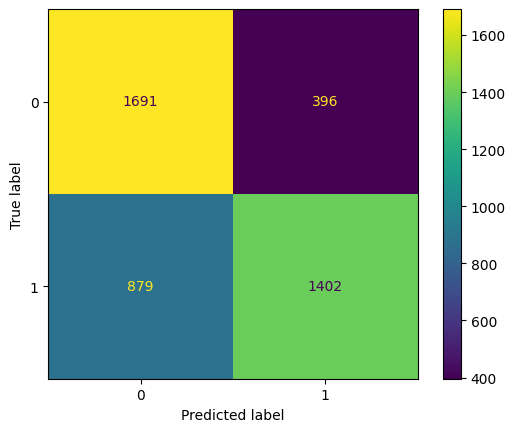

In [6]:
validate_lr_model(
    lr_model=lr_model1, 
    train_labels=process_data["encoded_train_labels"], 
    train_preds=lr1_train_preds, 
    test_labels=process_data["encoded_test_labels"],
    test_preds=lr1_test_preds)

### 6.2. Segundo experimento: TF-IDF

La configuración tanto de los datasets como del modelo son idénticas a las explicadas en el anterior experimento, a excepción de los dos siguientes aspectos:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **TF-IDF**. 

* La **regularización** escogida en este caso ha sido la **L2** con un valor de penalización por defecto establecido en 1.0 puesto que al aumentarlo (menos penalización) el sobreajuste incrementaba considerablemente, mientas que al decrementar el valor (más penalización) el rendimiento del modelo empeoraba ligeramente.

In [7]:
# Process the train and test documents
# Encode the class labels to numeric values for train and test datasets
process_data = process_encode_datasets(
    train_df=train_df,
    test_df=test_df,
    lemm=False, 
    stemm=True)

# Encode documents as TF-IDF values for train and test texts
tf_idf = to_tf_idf(
    train_docs=list(train_df["cleaned_text"].values), 
    test_docs=list(test_df["cleaned_text"].values))

# Create and configure a LR model
lr_model2 = LogisticRegression(
    multi_class="ovr", 
    solver="liblinear")

# Train the LR model
lr_model2.fit(
    X=tf_idf["train"], 
    y=process_data["encoded_train_labels"])

# Predict over the train dataset
lr2_train_preds = lr_model2.predict(X=tf_idf["train"])

# Predict over the test dataset
lr2_test_preds = lr_model2.predict(X=tf_idf["test"])

Tal y como se puede observar en los siguientes resultados, este segundo modelo parece caracterizarse por un **mayor sobreajuste** que el anterior puesto que la tasa de aciertos de entrenamiento es más de 14 puntos con respecto al conjunto de test. Un aspecto interesante ha sido la posibilidad de ajustar la configuración de entrenamiento obteniendo distintos resultados tras involucrar a una nueva técnica de codificación de textos. Con la misma **configuración anterior** el modelo del segundo experimento disponía de un **menor sobreajuste pero también un menor rendimiento**, mientras que con esta nueva configuración se dispara la tasa de aciertos en entrenamiento mientras que se resiente considerablemente en validación.

Training accuracy 0.876
Test accuracy 0.710
AUC 0.713


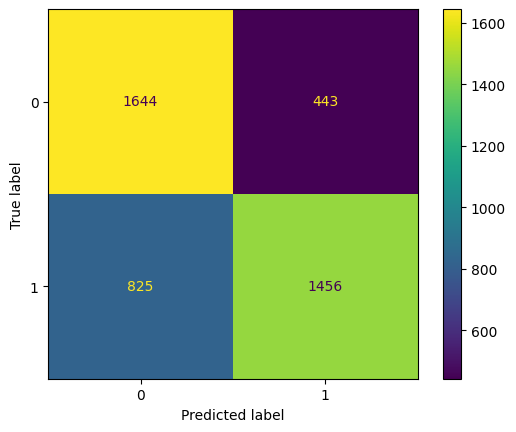

In [8]:
validate_lr_model(
    lr_model=lr_model2, 
    train_labels=process_data["encoded_train_labels"], 
    train_preds=lr2_train_preds, 
    test_labels=process_data["encoded_test_labels"],
    test_preds=lr2_test_preds)

### 6.3. Tercer experimento: generación de embeddings

#### 6.3.1. Codificación con Word2Vec

En este nuevo experimento la configuración de los conjuntos de datos es similar a las anteriores así como la del propio modelo de Regresión Logística, destacando los siguientes aspectos:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **Word2Vec** para generar *word embeddings* personalizados a los datasets. 

* La **regularización** escogida en este caso ha sido la **L2** puesto que se presenta una casuística parecida a la explicada en el experimento anterior.

In [9]:
# Process the train and test documents
# Encode the class labels to numeric values for train and test datasets
process_data = process_encode_datasets(
    train_df=train_df,
    test_df=test_df,
    lemm=False, 
    stemm=True)

# Encode documents as word embeddings for train and test texts
word2vec = word2vec_pipeline(
    train_df=train_df, 
    train_text_col="cleaned_text", 
    test_df=test_df, 
    test_text_col="cleaned_text",
    vector_size=100, 
    window=2, 
    min_count=4, 
    epochs=7, 
    alg=0)

# Create and configure a LR model
lr_model3 = LogisticRegression(
    multi_class="ovr", 
    solver="liblinear")

# Train the LR model
lr_model3.fit(
    X=word2vec["train"], 
    y=process_data["encoded_train_labels"])

# Predict over the train dataset
lr3_train_preds = lr_model3.predict(X=word2vec["train"])

# Predict over the test dataset
lr3_test_preds = lr_model3.predict(X=word2vec["test"])

Tras probar diversos valores para los distintos parámetros de la codificación de textos se han podido obtener las siguientes conclusiones:

* El rango para el parámetro *vector_size* se encuentra alrededor de 100 por lo que es necesario aumentar el tamaño de los embeddings para almacenar una **mayor cantidad de vocabulario** con la que posteriormente codificar los documentos de una manera más precisa y sin perder tanta información que con longitudes menores.

* El valor del parámetro *min_count* también es relevante puesto que si **aumenta demasiado el vocabulario** puede contener **demasiado ruido** y por ende las representaciones resultantes perjudican el rendimiento del clasificador. No obstante, si el valor es muy elevado el **vocabulario se reduce drásticamente perdiendo información**.

* Una situación similar ocurre con el número de **iteraciones** puesto que a **mayor número, más sobreajuste** puesto que mayor es la diferencia entre los aciertos de entrenamiento y validación, aunque si se **decrementa demasiado** el modelo puede no tener suficiente tiempo como para estudiar los datos y perder información **disminuyendo su rendimiento**.

* En relación al algoritmo utilizado para la codificación ha sido **CBWO** el que mejores resultados ha proporcionado siendo hasta un 5% más elevado en las tres métricas escogidas con respecto al algoritmo Skip-Gram. Por lo tanto para este conjunto de datos y utilizando Regresión Logística, es más factible intentar **predecir el siguiente término a partir del contexto** que no aplicando la arquitectura inversa.

* Finalmente se ha experimentado a entrenar un único modelo Word2Vec generando un vocabulario con sendos datasets, con únicamente el de entrenamiento o dos modelos, uno para cada conjunto. De las tres configuraciones la que mejores valores métricos ha conseguido ha sido la última en la que se entrena **un modelo Word2Vec por dataset**. Una de las posibles teorías explicativas de este fenómeno reside en que si bien el conjunto de entrenamiento solo está compuesto por *tweets*, el de validación también dispone de documentos procedentes de una segunda red social llamada *Gab* y un alto contenido en noticias, por lo que la **terminología** parece ser **considerablemente diferente entre datasets**.

Aún así las métricas reflejan un **clasificador prácticamente aleatorio** con muchísima menor capacidad de predicción que los anteriores que emplean otras codificaciones de textos. A diferencia de los experimentos anteriores, en este se presenta una **desmesurada tasa de falsos positivos**, es decir, textos no sexistas clasificados como positivos.

Training accuracy 0.560
Test accuracy 0.518
AUC 0.525


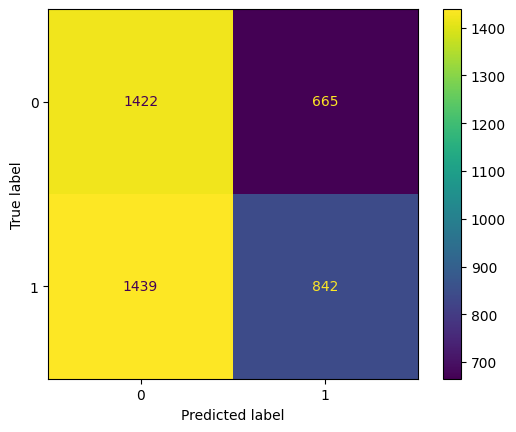

In [10]:
validate_lr_model(
    lr_model=lr_model3, 
    train_labels=process_data["encoded_train_labels"], 
    train_preds=lr3_train_preds, 
    test_labels=process_data["encoded_test_labels"],
    test_preds=lr3_test_preds)

#### 6.3.2. Codificación con Doc2Vec

Al igual que con la versión anterior se replica la misma configuración de los conjuntos de entrenamiento y validación para entrenar un modelo con Regresión Logística destacando los siguientes aspectos más relevantes:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **Doc2Vec** para generar *word embeddings* personalizados a los datasets. 

* La **regularización** escogida en este caso ha sido la **L2** con un valor ligeramente superior al valor por defecto por lo que aplicando una **menor penalización** el modelo presenta **mejores resultados**. Tanto con una mayor penalización como aplicando la regularización L1, los resultados de las métricas descienden hasta en más de 3 puntos. 

In [11]:
# Process the train and test documents
# Encode the class labels to numeric values for train and test datasets
process_data = process_encode_datasets(
    train_df=train_df,
    test_df=test_df,
    lemm=False, 
    stemm=True)

# Encode documents as doc embeddings for train and test texts
doc2vec = doc2vec_pipeline(
    train_df=train_df, 
    train_text_col="cleaned_text", 
    test_df=test_df, 
    test_text_col="cleaned_text", 
    vector_size=200, 
    window=5, 
    min_count=10, 
    epochs=2, 
    alg=1)

# Create and configure a LR model
lr_model4 = LogisticRegression(
    multi_class="ovr", 
    solver="liblinear", 
    penalty="l2", 
    C=1.5)

# Train the LR model
lr_model4.fit(
    X=doc2vec["train"], 
    y=process_data["encoded_train_labels"])

# Predict over the train dataset
lr4_train_preds = lr_model4.predict(X=doc2vec["train"])

# Predict over the test dataset
lr4_test_preds = lr_model4.predict(X=doc2vec["test"])

Tras probar diversos valores para los distintos parámetros de la codificación de textos se han podido obtener las siguientes conclusiones:

* El rango para el parámetro *vector_size* es más elevado que con la técnica *Word2Vec* necesitando **vectores de mayor longitud** para encapsular más información que ayude al modelo a obtener un mejor rendimiento. La teoría explicativa más plausible para este aumento de tamaño puede estar relacionada con la característica adicional que presenta esta variante al incluir la **representación de los párrafos** en los que se encuentran los términos, ya que ocupan una mayor longitud que los propios conceptos.

* El valor del parámetro *min_count* también ha **aumentado su valor** para mejorar el rendimiento del modelo por lo que parece necesario **restringir más los términos** que aparecen en el vocabulario que en la variante anterior. Así se obtiene un vocabulario más preciso pese a que la representación de los textos ocupe una mayor cantidad de memoria.

* Una situación similar ocurre con el número de **iteraciones** puesto que a **mayor número, más sobreajuste** puesto que mayor es la diferencia entre los aciertos de entrenamiento y validación, aunque si se **decrementa demasiado** el modelo puede no tener suficiente tiempo como para estudiar los datos y perder información **disminuyendo su rendimiento**.

* Mientras que los experimentos con el algoritmo **PV-DBOW apenas han hecho variar el rendimiento del modelo**, la segunda opción **PV-DM** es la que ha proporcionado una **mayor variabilidad y respuesta** ante los cambios de los parámetros y por ende el mejor modelo encontrado para esta configuración. De nuevo el enfoque de entrenamiento de *embeddings* que parece ser más efectivo es la **predicción de términos a partir de un contexto** proporcionado.

A pesar de las diferencias destacadas entre ambas técnicas, este nuevo clasificador resultante también presenta un **comportamiento prácticamente aleatorio** por sus ínfimas tasas de aciertos tanto en entrenamiento como en validación, además de un valor AUC casi despreciable que confirma el nulo aprendizaje del modelo. Como en el experimento previo destaca una fortísima tasa de **falsos positivos** si observamos la matriz de confusión.

Training accuracy 0.533
Test accuracy 0.542
AUC 0.531


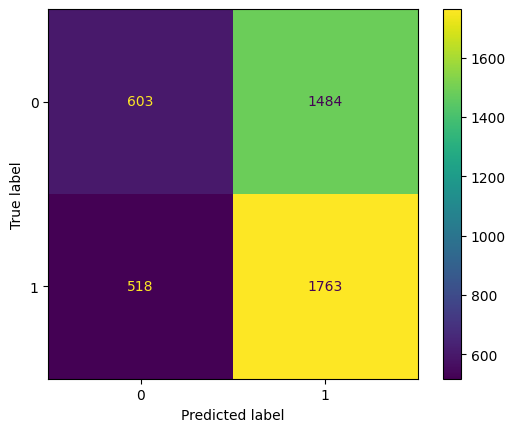

In [12]:
validate_lr_model(
    lr_model=lr_model4, 
    train_labels=process_data["encoded_train_labels"], 
    train_preds=lr4_train_preds, 
    test_labels=process_data["encoded_test_labels"],
    test_preds=lr4_test_preds)

#### 6.3.3. Codificación con FastText

Tras realizar múltiples experimentos con distintas combinaciones de técnicas de procesamiento de textos, hiperparametrización para construir un modelo de codificación de textos utilizando FastText así como una segunda hiperparametrización para configurar el clasificador con Regresión Logística, **ninguno de los modelos proporcionados han sido capaces de mejorar el rendimiento** demostrado hasta el momento. Sus métricas son muy similares al experimento anterior con *Doc2Vec* por lo que **no parece aportar ningún valor para su inclusión** en este notebook.

Una posible teoría explicativa fundamentada en la definición de *FastText* puede residir en el **escaso volumen de documentos** disponibles para el problema de sexismo que se trata de abordar. 


#### 6.3.4. Embeddings pre-entrenados

En esta última sección se ha experimentado con diferentes modelos pre-entrenados que disponen de un conjunto de *embeddings* listo para codificar los documentos de entrenamiento y validación. A continuación se exponen los resultados que se han obtenido de manera general y específica a ciertos modelos.

* Por agilizar la experimentación únicamente se han probado los **modelos más ligeros** en cuanto a tamaño se refiere, con un rango de entre 100MB y 300MB.

* La mayoría de modelos experimentados **generan valores peridos** al intentar codificar los documentos de entrenamiento y validación, por lo que su tratamiento debe ser considerado para el empleo de ciertos algoritmos de Aprendizaje Automático, como es el caso de la Regresión Logística que es totalmente incompatible con este tipo de valores.

* Las métricas de *accuracy*, *AUC* y la matriz de confusión muestran **resultados similares a los experimentos anteriores** en los que se generaban *embeddings* específicos para los datasets. Por lo tanto, de momento utilizando únicamente Regresión Logística no parece que se puedan vislumbrar las diferencias y ventajas de usar *embeddings* pre-entrenados o generarlos de manera personalizada a nuestro problema.

In [25]:
# Process the train and test documents
# Encode the class labels to numeric values for train and test datasets
process_data = process_encode_datasets(
    train_df=train_df,
    test_df=test_df,
    lemm=False, 
    stemm=True)

# Download and load pre-trained models with ready-to-use embeddings
trained_embeddings = trained_embeddings_pipeline(
    train_df=train_df, 
    train_text_col="cleaned_text", 
    test_df=test_df, 
    test_text_col="cleaned_text", 
    model="word2vec-ruscorpora-300",
    vector_size=100)

# Create and configure a LR model
lr_model5 = LogisticRegression(
    multi_class="ovr", 
    solver="liblinear")

# Train the LR model
lr_model5.fit(
    X=trained_embeddings["train"].dropna(), 
    y=process_data["encoded_train_labels"])

# Predict over the train dataset
lr5_train_preds = lr_model5.predict(X=trained_embeddings["train"].dropna())

# Predict over the test dataset
lr5_test_preds = lr_model5.predict(X=trained_embeddings["test"].dropna())

# Model validation over train and test datasets
validate_lr_model(
    lr_model=lr_model5, 
    train_labels=process_data["encoded_train_labels"], 
    train_preds=lr5_train_preds, 
    test_labels=process_data["encoded_test_labels"],
    test_preds=lr5_test_preds)

## 7. Conclusiones

Después de experimentar con diferentes configuraciones de codificación de textos y entrenamiento de modelos con Regresión Logística, a continuación se resumen las claves más relevantes que se han extraído durante la generación de este notebook:

* Si bien el algoritmo de Regresión Logística para entrenar los clasificadores es profundamente sencillo, el objetivo se orientaba más hacia el **estudio y comprensión de las metodologías de codificación de textos**. Por lo tanto debemos considerar que los resultados obtenidos **no permiten descartar** a unas u otras puesto que la Regresión Logística no está pensada para abordar problemas de clasificación de textos.

* De las experimentaciones realizadas destacan principalmente las dos primeras en las que se empleaban **Bolsas de Palabras** y **TF-IDF** por sus **mejores resultados** en base a las métricas consideradas de *accuracy* en entrenamiento y test, *AUC* y matriz de confusión. Si bien han sido **las más sencillas** de conocer, implementar y analizar, han demostrado disponer de una **suficiente capacidad de representación** para construir clasificadores medianamente decentes con un algoritmo estadístico como es la Regresión Logística.

* En relación al **entrenamiento de embeddings** personalizados en los conjuntos de datos se han podido experimentar con diversas técnicas que son prácticamente **todas variantes de Word2Vec**. En estos casos los **resultados no han sido aceptables** pero de nuevo intuyo un gran potencial si son combinados con arquitecturas más complejas y específicamente diseñadas para la clasificación de textos, como redes LSTM. Del mismo modo ocurre con el uso de **embeddings pre-entrenados**, en cuya mayoría apenas se han podido entrenar clasificadores por su generación de valores nulos y la incompatibilidad de tratar este tipo de datos por parte de la Regresión Logística.

* Una conclusión general a todos los modelos ha sido el **aumento del sobreajuste** presentado conforme **aumenta la complejidad de la codificación de textos**. Este fenómeno probablemente esté únicamente asociado al empleo de la Regresión Logística para la construcción de los clasificadores pero ha sido inesperado por mi parte y por tanto debe ser destacado como precaución a tomar en el uso de arquitecturas más complejas.